In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from functools import partial
import scipy as sp
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [83]:
# Verification: read the files into dataframes
files = ["../Data/model_data/model-encoded-data-0.csv", 
         "../Data/model_data/model-encoded-data-1.csv", 
         "../Data/model_data/model-encoded-data-2.csv"]
model_dfs = [pd.read_csv(f, sep=",", 
                          encoding='Latin-1', 
                          low_memory=False ) for f in files]

# combine the list of dataframes
df = pd.concat(model_dfs, ignore_index=True)

In [84]:
df.head()

,is_female,is_male,is_gender_non_confirming,is_transgender,is_gender_unknown,is_age_18_to_24,is_age_25_to34,is_age_35_44,is_age_45_54,is_age_55_to_64,...,is_company_size_below_100,compensation,year,country,IT_experience_in_years,occupation,proficient_languages,desktop_OS,job_satisfaction,GDP
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,20000-40000,2011,United States,2_to_5,"Executive (VP of Eng, CTO, CIO, etc.)","['JavaScript', 'CSS', 'PHP', 'Python', 'SQL', ...",Windows 7,5.0,50065.966504
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,80000-100000,2011,United States,6_to_10,Web Application Developer,"['JavaScript', 'CSS', 'PHP', 'SQL']",Linux,6.0,50065.966504
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,80000-100000,2011,Germany,above_11,Desktop Application Developer,['C#'],Windows 7,6.0,46705.895796
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,60000-80000,2011,United Kingdom,above_11,IT Staff / System Administrator,"['SQL', 'C#', 'C++', 'C']",Windows 7,6.0,42284.884490
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,40000-60000,2011,United Kingdom,above_11,Web Application Developer,"['JavaScript', 'Python', 'SQL', 'C++', 'C', 'P...",Linux,5.0,42284.884490


In [85]:
#For now don't use these columns as they are not processed yet
cols_excl = ['occupation', 'proficient_languages', 'desktop_OS', 'country', 'year', 'IT_experience_in_years']
df = df.drop(cols_excl, axis=1)

In [86]:
#df_salary is a dataframe after dropping data points with NaN in 'compensation'
df_salary = df.dropna(subset=['compensation'])[df.dropna(subset=['compensation'])['compensation']!=0]
print('Dataframe without NaN and 0 in compensation is {}%'.format(round(len(df_salary)/len(df)*100, 2)), 'of the original dataframe.')
print('There are {}'.format(len(df_salary)), 'data points in it compared to {}'.format(len(df)), 'entries in the original dataframe.\n')
print('Information on missing values in the dataframe df_salary:')
df_salary.isna().sum()/len(df_salary)*100

Dataframe without NaN and 0 in compensation is 100.0% of the original dataframe.
There are 257260 data points in it compared to 257260 entries in the original dataframe.

Information on missing values in the dataframe df_salary:


is_female                       0.0
is_male                         0.0
is_gender_non_confirming        0.0
is_transgender                  0.0
is_gender_unknown               0.0
is_age_18_to_24                 0.0
is_age_25_to34                  0.0
is_age_35_44                    0.0
is_age_45_54                    0.0
is_age_55_to_64                 0.0
is_age_above_65                 0.0
is_age_below_18                 0.0
is_company_size_1000_to_4999    0.0
is_company_size_100_to_499      0.0
is_company_size_5000_to_9999    0.0
is_company_size_500_to_999      0.0
is_company_size_unknown         0.0
is_company_size_above_10000     0.0
is_company_size_below_100       0.0
compensation                    0.0
job_satisfaction                0.0
GDP                             0.0
dtype: float64

In [87]:
df_salary['compensation'].unique()

array(['20000-40000', '80000-100000', '60000-80000', '40000-60000',
       '140000-160000', '100000-120000', 'below-20000', '120000-140000',
       'above-160000', '60000_to_80000'], dtype=object)

In [88]:
comp_int_dict = {'below-20000': 1, '20000-40000': 2, '40000-60000': 3, '60000_to_80000': 4, '60000-80000': 4, 
                 '80000-100000': 5,'100000-120000': 6, '12000-140000': 7, '120000-140000':7,
                 '140000-160000': 8, 'above-160000': 9}

In [89]:
df_salary.replace({'compensation':comp_int_dict}, inplace=True)

In [101]:
df_salary.head()

,is_female,is_male,is_gender_non_confirming,is_transgender,is_gender_unknown,is_age_18_to_24,is_age_25_to34,is_age_35_44,is_age_45_54,is_age_55_to_64,...,is_company_size_1000_to_4999,is_company_size_100_to_499,is_company_size_5000_to_9999,is_company_size_500_to_999,is_company_size_unknown,is_company_size_above_10000,is_company_size_below_100,compensation,job_satisfaction,GDP
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,5.0,50065.966504
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,6.0,50065.966504
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,6.0,46705.895796
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,6.0,42284.884490
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,5.0,42284.884490


In [138]:
#Define data (predictors) and response
data_df = df_salary.drop('compensation', axis=1)

# Some code to scale numerical data
cols_to_scale = ['job_satisfaction', 'GDP']
train_numerical = data_df[cols_to_scale].copy()
sc = StandardScaler()
sc.fit(train_numerical)
train_scaled = sc.transform(train_numerical)
train_scaled = pd.DataFrame(train_scaled, columns = train_numerical.columns)
data_df_scaled = pd.concat([data_df.drop(cols_to_scale, axis=1), train_scaled], axis=1)
display(data_df_scaled.head()) #scaled job satisfaction and GDP data
 
print(data_df_scaled.columns) #checking that 'compensation' is not there
# data = data_df_scaled.to_numpy()
#Temporarily drop GDP
data = data_df_scaled.drop('GDP', axis=1).to_numpy()
salary = df_salary['compensation'].to_numpy()

,is_female,is_male,is_gender_non_confirming,is_transgender,is_gender_unknown,is_age_18_to_24,is_age_25_to34,is_age_35_44,is_age_45_54,is_age_55_to_64,...,is_age_below_18,is_company_size_1000_to_4999,is_company_size_100_to_499,is_company_size_5000_to_9999,is_company_size_500_to_999,is_company_size_unknown,is_company_size_above_10000,is_company_size_below_100,job_satisfaction,GDP
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.439681,0.484270
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.739888,0.484270
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.739888,0.341517
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.739888,0.153691
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.439681,0.153691


Index(['is_female', 'is_male', 'is_gender_non_confirming', 'is_transgender',
       'is_gender_unknown', 'is_age_18_to_24', 'is_age_25_to34',
       'is_age_35_44', 'is_age_45_54', 'is_age_55_to_64', 'is_age_above_65',
       'is_age_below_18', 'is_company_size_1000_to_4999',
       'is_company_size_100_to_499', 'is_company_size_5000_to_9999',
       'is_company_size_500_to_999', 'is_company_size_unknown',
       'is_company_size_above_10000', 'is_company_size_below_100',
       'job_satisfaction', 'GDP'],
      dtype='object')


In [139]:
np.unique(salary)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [140]:
data.shape

(257260, 20)

In [141]:
salary.shape

(257260,)

In [142]:
#Could be nice for visualization for model report, compare with real values
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert (len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


#Could be used to include in a model report, compare with real values
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

#Define evaluation metric
def quadratic_weighted_kappa(y, y_pred):
    rater_a = y
    rater_b = y_pred
    min_rating = None
    max_rating = None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert (len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

## Light Gradient Boosting Machine regressor ##

**Rounding to nearest integer**

5-fold CV

In [143]:
#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)

cv_scores = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]    
    model = lgb.LGBMRegressor()
    pred = model.fit(X_train, y_train).predict(X_test).astype(np.int32) #rounding to nearest integer
    qwk = quadratic_weighted_kappa(pred,y_test)
    cv_scores[idx] = qwk

In [144]:
print('For LGBM rounding to the nearest integer the mean quadratic weighted kappa score in stratified 5-fold CV is {}.'.format(np.mean(cv_scores)))

For LGBM rounding to the nearest integer the mean quadratic weighted kappa score in stratified 5-fold CV is 0.25339416372687185.


**Optimized rounding**

In [145]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            elif pred >= coef[4] and pred < coef[5]:
                X_p[i] = 5
            elif pred >= coef[5] and pred < coef[6]:
                X_p[i] = 6
            elif pred >= coef[6] and pred < coef[7]:
                X_p[i] = 7
            elif pred >= coef[7] and pred < coef[8]:
                X_p[i] = 8
            else:
                X_p[i] = 9
        return X_p

    def coefficients(self):
        return self.coef_['x']

#Split data into train and test datasets - do again to ensure variables are correctly assigned
data_train, data_test, labels_train, labels_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)

cv_scores_opt = np.empty(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

coefficients_arr = 0
#For train set, make further splits for CV
for idx, (train_idx, test_idx) in enumerate(cv.split(data_train, labels_train)):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = labels_train[train_idx], labels_train[test_idx]    
    model = lgb.LGBMRegressor()
    pred = model.fit(X_train, y_train).predict(X_test)
    optR = OptimizedRounder()
    optR.fit(pred, y_test)
    coefficients = optR.coefficients()
    coefficients_arr+=coefficients
    pred_test_y_k = optR.predict(pred, coefficients)
    qwk = quadratic_weighted_kappa(pred_test_y_k,y_test)
    cv_scores_opt[idx] = qwk

In [146]:
print('Mean quadratic weighted kappa score for stratified 5-fold CV for LGBM regressor is', np.mean(cv_scores_opt))

Mean quadratic weighted kappa score for stratified 5-fold CV for LGBM regressor is 0.30581641928432246


Fitting and evaluation of model for test set

In [147]:
#Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(data, salary, test_size = 0.2, random_state = 0)

test_y = y_test
gbm_reg = lgb.LGBMRegressor()
gbm_reg.fit(X=x_train, y=y_train)
pred_test_y = gbm_reg.predict(x_test)
gbm_reg_pred = pred_test_y

coefficients_final = coefficients_arr/5 #using means of optimized coefficients from CV
print('Coefficients final are', coefficients_final)

optR = OptimizedRounder()
optR.coef_ = coefficients_final
pred_test_y_k = optR.predict(gbm_reg_pred, coefficients_final)
print('gbm_reg_pred is', gbm_reg_pred)
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients_final)
qwk = quadratic_weighted_kappa(test_y, pred_test_y_k)
print("QWK = ", qwk)

Coefficients final are [0.48328132 1.54643287 3.55075195 3.74037564 4.33244045 5.4327713
 5.85292905 6.67187097 7.24080451]
gbm_reg_pred is [4.27038406 5.44662748 4.21589796 ... 4.7733593  3.13578995 3.89982269]
Predicted Counts =  Counter({2.0: 21324, 5.0: 12347, 4.0: 11983, 3.0: 2675, 6.0: 1632, 7.0: 1077, 1.0: 380, 8.0: 34})
Coefficients =  [0.48328132 1.54643287 3.55075195 3.74037564 4.33244045 5.4327713
 5.85292905 6.67187097 7.24080451]
QWK =  0.30578253332355754


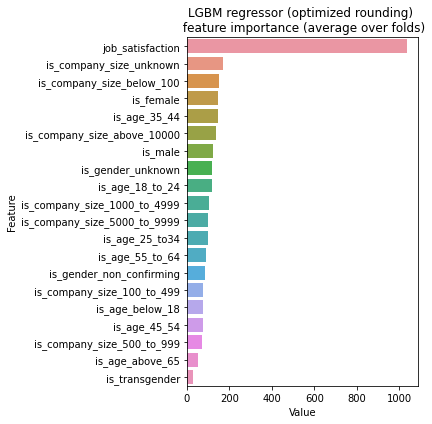

In [148]:
feature_imp = pd.DataFrame(sorted(zip(gbm_reg.feature_importances_,data_df.columns)), columns=['Value','Feature'])

plt.figure(figsize=(6, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBM regressor (optimized rounding) \n feature importance (average over folds)')
plt.tight_layout()
plt.savefig('LGBM regressor (optimized rounding) feature importance (average over folds).svg')
plt.show()

## Light Gradient Boosting Machine classifier ##